In [88]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math,os
import pickle

# from tqdm import tqdm,trange, tqdm_notebook
from tqdm import tqdm_notebook as tqdm
import numpy.linalg as npl
import itertools
import scipy.special,time, scipy.stats
from collections import Counter
from scipy.special import comb as choose

In [89]:

nArr = np.round(np.logspace(np.log2(200),np.log2(20000),num=20,base=2)).astype(int)
numTrials = 20


adaData = np.zeros((len(nArr),numTrials))
errorProb = np.zeros(len(nArr))
numExactComp = np.zeros((len(nArr),numTrials))
gapArrs = []
estMeanArrs=[]
numPullArrs = []

bruteTimes = np.zeros(len(nArr))
rutsTimes = np.zeros(len(nArr))
for (j,n) in enumerate(nArr):
    
    myData = pickle.load( open( "pkls/bruteSim_{}.pkl".format(n), "rb" ) )
    bruteTimes[j] = myData['time']
    
    myData = pickle.load( open( "pkls/rutsSim_{}.pkl".format(n), "rb" ) )
    rutsTimes[j] = myData['time']
    
    
    bestArm = 0
    gapArr = np.zeros((numTrials,n-1))
    estMeanArr = np.zeros((numTrials,n))
    numPullArr = np.zeros((numTrials,n))
    for i in range(numTrials):
        myData = pickle.load( open( "pkls/adaSim_{}_{}.pkl".format(n,i), "rb" ) )
        adaData[j,i] = myData[7]
        numExactComp[j,i] = myData[4]
        if i%2==0:
            bestArm = myData[3]
        if i%2==1 and myData[3]!=bestArm:
            errorProb[j]+=1
            
        numPullArr[i] = myData[5]
        estMeans = myData[6]
        gaps = estMeans.max() - estMeans
        gaps = gaps[gaps>0]
        gapArr[i] = gaps
        estMeanArr[i] = estMeans
    estMeanArrs.append(estMeanArr)
    gapArrs.append(gapArr)
    numPullArrs.append(numPullArr)
#     print(myData[2],adaData[j].mean(),numExactComp[j].mean())
# timeArr/= numTrials

In [91]:
nArr

array([  200,   255,   325,   414,   527,   672,   856,  1091,  1390,
        1772,  2258,  2877,  3666,  4671,  5953,  7585,  9666, 12317,
       15695, 20000])

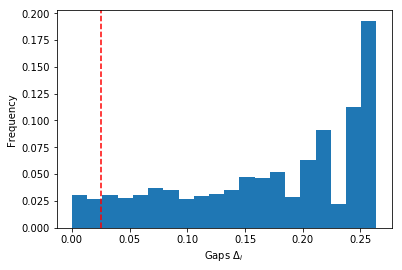

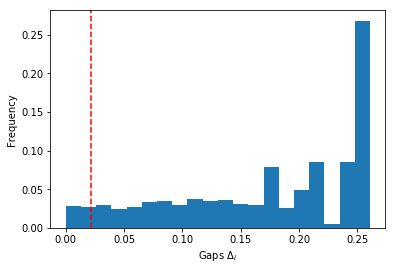

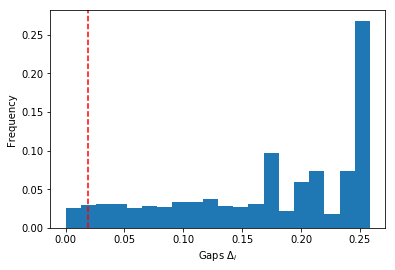

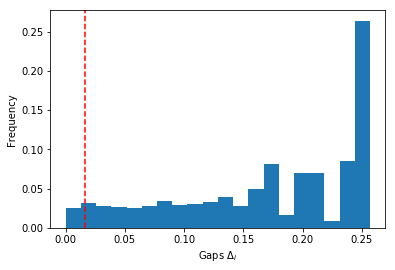

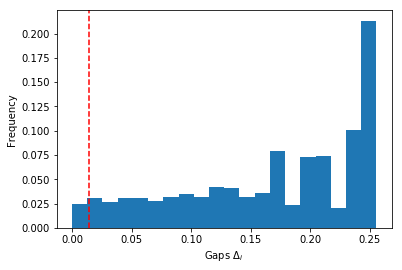

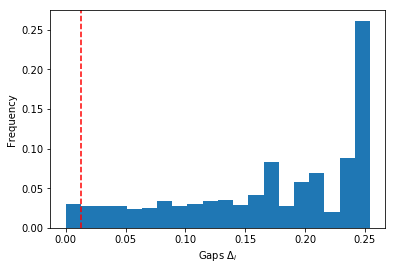

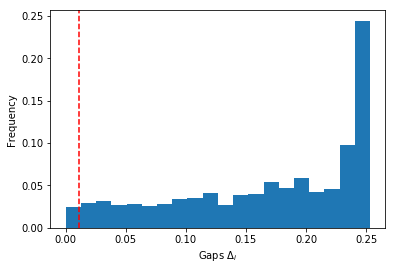

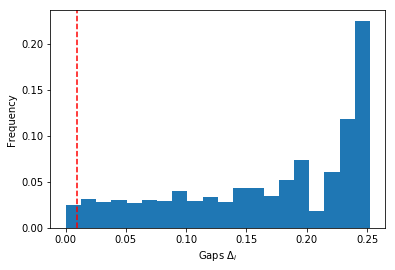

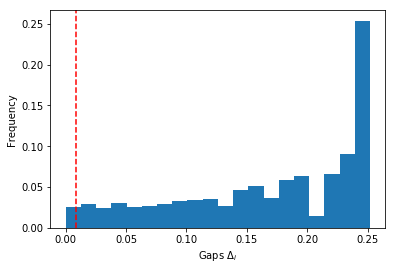

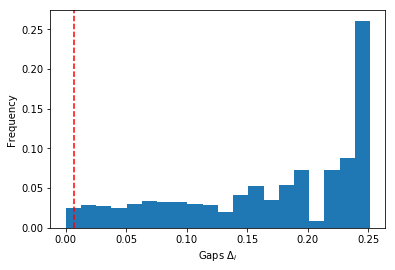

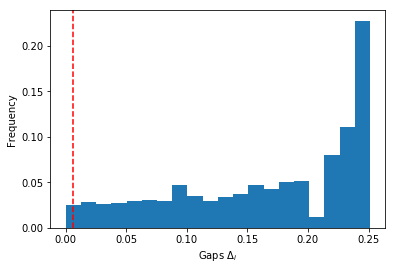

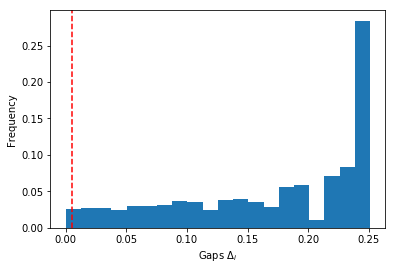

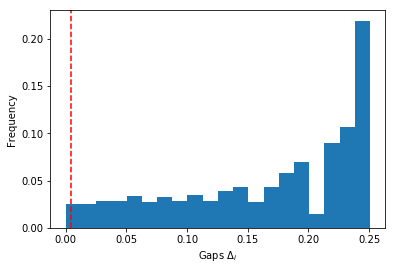

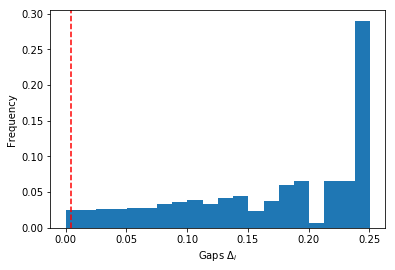

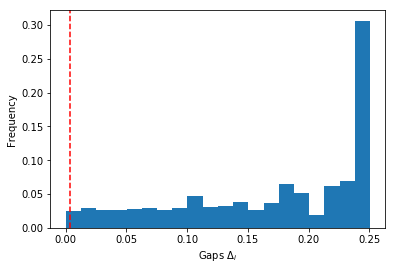

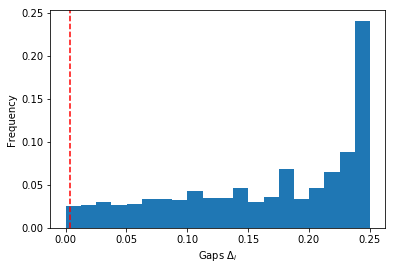

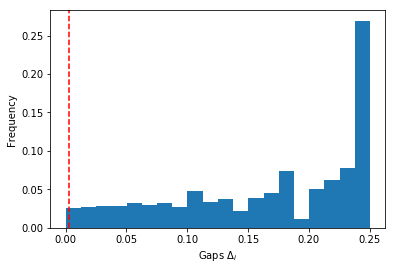

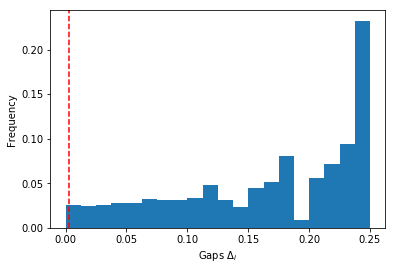

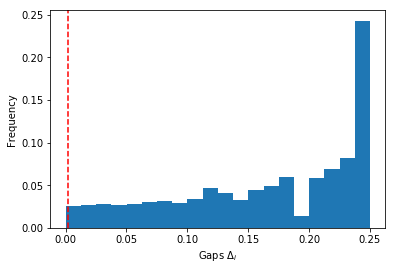

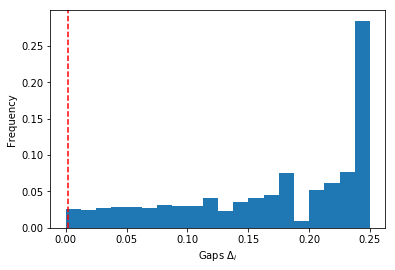

In [94]:
for (idx,n) in enumerate(nArr):
    plt.figure()
#     idx = -1
#     n= nArr[idx]
    threshold = n*np.log2(n)
    myArr = gapArrs[idx].flatten()
    plt.hist(myArr,bins=20, weights = np.ones(myArr.size)/myArr.size)
    plt.axvline(threshold**(-1/2), linestyle='--',c='r')
    plt.xlabel(r'Gaps $\Delta_i$')
    plt.ylabel('Frequency')
    plt.savefig('plots/gapPlots/n_{}_gaps.pdf'.format(n))

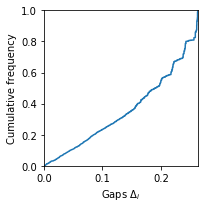

In [87]:
plt.figure(figsize=(3,3))
idx = 0
a = gapArrs[idx].flatten()
plt.plot(np.sort(a), np.linspace(0, 1, len(a), endpoint=False))
plt.xlabel(r'Gaps $\Delta_i$')
plt.ylabel('Cumulative frequency')
plt.xlim((0,max(a)))
plt.ylim((0,1))
plt.tight_layout()
plt.savefig('plots/n20kgapsCDF.pdf',bbox_inches='tight',pad_inches=0.0)

In [66]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(np.sort(a)[1:]), np.log(np.linspace(0, 1, len(a), endpoint=False)[1:]))


In [67]:
slope

1.16200966975493

0.9807651901123543


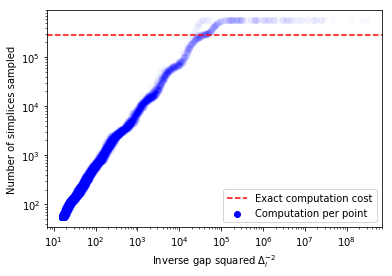

In [33]:
plt.figure()
x = []
y = []
idx = -1
n=nArr[idx]
gaps = np.zeros(n)
numPulls = np.zeros(n)
for i in range(numTrials):
    
    
    gaps += estMeanArrs[idx][i].max()-estMeanArrs[idx][i]
    numPulls += numPullArrs[idx][i]

gaps/=numTrials
numPulls/= numTrials
plt.scatter(gaps[gaps>0]**(-2),numPulls[gaps>0],alpha=.02,color='b',label='Computation per point')
x.append(list(gaps[gaps>0]**(-2)))
y.append(list(numPulls[gaps>0]))

# for it in range(10):
#     gaps = np.zeros(n)
#     numPulls = np.zeros(n)
#     for j in range(2):
#         i = it*2 + j
#         gaps += estMeanArrs[idx][i].max()-estMeanArrs[idx][i]
#         numPulls += numPullArrs[idx][i]

#     plt.scatter(gaps[gaps>0]**(-2),numPulls[gaps>0],alpha=.5,color='b')
#     x.append(list(gaps[gaps>0]**(-2)))
#     y.append(list(numPulls[gaps>0]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Inverse gap squared $\Delta_i^{-2}$')
plt.ylabel('Number of simplices sampled')
threshold = n*np.log2(n)
plt.axhline(n*np.log2(n), linestyle='--',c='r', label='Exact computation cost')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)


x = np.array(x)
y=np.array(y)
x = x[y<threshold]
y = y[y<threshold]


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
# xrange = np.arange(30,10**4)
# plt.plot(xrange,xrange*slope+intercept)
print(r_value**2)
plt.savefig('plots/pullsVsGap.pdf')

<Figure size 432x288 with 0 Axes>

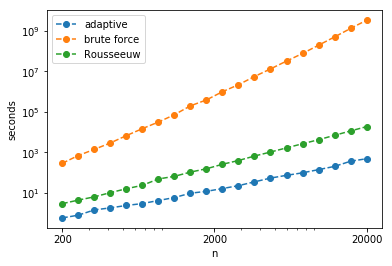

In [71]:
plt.figure()
fig1, ax1 = plt.subplots()

s=0
bruteSlope,_,_,_,_ = scipy.stats.linregress(np.log(nArr)[s:], np.log(bruteTimes)[s:])
rutSlope,_,_,_,_ = scipy.stats.linregress(np.log(nArr)[s:], np.log(rutsTimes)[s:])
adaSlope,_,_,_,_ = scipy.stats.linregress(np.log(nArr)[s:], np.log(adaData.mean(axis=1)[s:]))

plt.plot(nArr,np.mean(adaData,axis=1),'--o',label='adaptive')
plt.plot(nArr,bruteTimes,'--o',label='brute force')
plt.plot(nArr,rutsTimes,'--o', label = 'Rousseeuw')

plt.ylabel('seconds')
plt.xlabel('n')

plt.xscale('log')
plt.yscale('log')
ax1.set_xscale('log')
ax1.set_xticks([200,2000,20000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend()
plt.savefig('plots/adaWithRousseeuw2d_20k.pdf')

In [66]:
print(bruteSlope,rutSlope,adaSlope)

3.5200146247497512 1.9083721159655263 1.4337529367271324


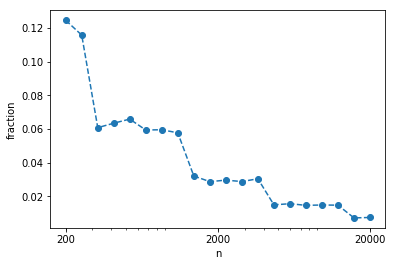

In [68]:
plt.plot(nArr,np.mean(numExactComp,axis=1)/nArr,'--o')
# plt.title('Fraction of simplicial depths exactly computed')
plt.ylabel('fraction')
plt.xlabel('n')
ax=plt.gca()
ax.set_xscale('log')
ax.set_xticks([200,2000,20000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.show()
plt.savefig('plots/ada2dFracExactComp20k.pdf')